### Steel Plate Defect Prediction
###### Set up for multi-label classification, where each sample can belong to multiple classes simultaneously, I used various classifiers and evaluating their performance using cross-validation and the area under the ROC curve (AUC) as the evaluation metric. 

#### Import libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 500)
pd.set_option("expand_frame_repr", True)

#### Data Collection

In [22]:
df_train = pd.read_csv("../data/train.csv", index_col="id")
df_test = pd.read_csv("../data/test.csv", index_col="id")
df_submission = pd.read_csv("../data/sample_submission.csv")

print(f"Train data: {df_train.shape} \nTest data: {df_test.shape}, \nSubmission data: {df_submission.shape}")
df_train

Train data: (19219, 34) 
Test data: (12814, 27), 
Submission data: (12814, 8)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,143210,143219,17,4,4,2193,122,140,1360,0,0,50,0.8950,0.1500,0.8571,0.0044,1.0000,0.8000,0.0,1.2305,0.7782,0.6021,-0.1429,0.0044,0.2901,0,0,0,1,0,0,0
19215,723,735,2488529,2488541,231,17,26,27135,104,133,1652,1,0,70,0.9243,0.3254,0.2778,0.0065,0.7333,0.9216,1.0,2.3636,1.0414,1.4150,0.7222,-0.0989,0.5378,0,0,0,0,0,0,1
19216,6,31,1578055,1578129,780,114,98,71112,41,94,1358,0,1,200,0.0148,0.4331,0.2281,0.0199,0.1862,0.9554,1.0,2.8921,1.4314,1.8692,0.7719,-0.4283,0.9997,1,0,0,0,0,0,0


#### Data Cleaning and Preprocessing

In [23]:
features = [
    "X_Minimum", "X_Maximum", "Y_Minimum", "Y_Maximum",
    "Pixels_Areas", "X_Perimeter", "Y_Perimeter", "Sum_of_Luminosity",
    "Minimum_of_Luminosity", "Maximum_of_Luminosity", "Length_of_Conveyer",
    "TypeOfSteel_A300", "TypeOfSteel_A400", "Steel_Plate_Thickness",
    "Edges_Index", "Empty_Index", "Square_Index", "Outside_X_Index",
    "Edges_X_Index", "Edges_Y_Index", "Outside_Global_Index", "LogOfAreas",
    "Log_X_Index", "Log_Y_Index", "Orientation_Index", "Luminosity_Index",
    "SigmoidOfAreas"
]

targets = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

# Defining X(features) and Y(targets)
X = df_train.drop(columns=targets)
y = df_train[targets]
print(f"Features -> {X.shape} Targets -> {y.shape}")

# Analyze the missing values and duplicates in the DataFrame
def analyze_missing_and_duplicates(data: pd.DataFrame) -> pd.DataFrame:
    n = data.shape[0]
    ret = pd.DataFrame(data.isnull().sum(), columns=["missing_number"])
    ret["pourcentage_missing_number"] = (ret["missing_number"] / n) * 100
    ret["types"] = data.dtypes
    ret["duplicate"] = data.duplicated(keep=False).sum()
    ret["NAN"] = data.isna().sum()
    return pd.DataFrame(ret)


analyze_missing_and_duplicates(df_train)

Features -> (19219, 27) Targets -> (19219, 7)


,missing_number,pourcentage_missing_number,types,duplicate,NAN
X_Minimum,0,0.0,int64,0,0
X_Maximum,0,0.0,int64,0,0
Y_Minimum,0,0.0,int64,0,0
Y_Maximum,0,0.0,int64,0,0
Pixels_Areas,0,0.0,int64,0,0
X_Perimeter,0,0.0,int64,0,0
Y_Perimeter,0,0.0,int64,0,0
Sum_of_Luminosity,0,0.0,int64,0,0
Minimum_of_Luminosity,0,0.0,int64,0,0
Maximum_of_Luminosity,0,0.0,int64,0,0


In [24]:
# Define preprocessing steps for numerical and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features)])

#### Feature Engineering

In [25]:
class FeatureEngineering:
    # A class to perform feature engineering on the input data.
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X):
        epsilon = 1e-6

        # Location Features
        X["X_Distance"] = X["X_Maximum"] - X["X_Minimum"]
        X["Y_Distance"] = X["Y_Maximum"] - X["Y_Minimum"]

        # Density Feature
        X["Density"] = X["Pixels_Areas"] / (X["X_Perimeter"] + X["Y_Perimeter"])

        # Relative Perimeter Feature
        X["Relative_Perimeter"] = X["X_Perimeter"] / (X["X_Perimeter"] + X["Y_Perimeter"] + epsilon)

        # Circularity Feature
        X["Circularity"] = X["Pixels_Areas"] / (X["X_Perimeter"] ** 2)

        # Symmetry Index Feature
        X["Symmetry_Index"] = np.abs(X["X_Distance"] - X["Y_Distance"]) / (X["X_Distance"] + X["Y_Distance"] + epsilon)

        # Color Contrast Feature
        X["Color_Contrast"] = X["Maximum_of_Luminosity"] - X["Minimum_of_Luminosity"]

        # Combined Geometric Index Feature
        X["Combined_Geometric_Index"] = X["Edges_Index"] * X["Square_Index"]

        # Interaction Term Feature
        X["X_Distance*Pixels_Areas"] = X["X_Distance"] * X["Pixels_Areas"]

        # Additional Features
        X["sin_orientation"] = np.sin(X["Orientation_Index"])
        X["Edges_Index2"] = np.exp(X["Edges_Index"] + epsilon)
        X["X_Maximum2"] = np.sin(X["X_Maximum"])
        X["Y_Minimum2"] = np.sin(X["Y_Minimum"])
        X["Aspect_Ratio_Pixels"] = np.where(X["Y_Perimeter"] == 0, 0, X["X_Perimeter"] / X["Y_Perimeter"])
        X["Aspect_Ratio"] = np.where(X["Y_Distance"] == 0, 0, X["X_Distance"] / X["Y_Distance"])

        # Average Luminosity Feature
        X["Average_Luminosity"] = (X["Sum_of_Luminosity"] + X["Minimum_of_Luminosity"]) / 2

        # Normalized Steel Thickness Feature
        X["Normalized_Steel_Thickness"] = (X["Steel_Plate_Thickness"] - X["Steel_Plate_Thickness"].min()) / (X["Steel_Plate_Thickness"].max() - X["Steel_Plate_Thickness"].min())

        # Logarithmic Features
        X["Log_Perimeter"] = np.log(X["X_Perimeter"] + X["Y_Perimeter"] + epsilon)
        X["Log_Luminosity"] = np.log(X["Sum_of_Luminosity"] + epsilon)
        X["Log_Aspect_Ratio"] = np.log(X["Aspect_Ratio"] ** 2 + epsilon)

        # Statistical Features
        X["Combined_Index"] = X["Orientation_Index"] * X["Luminosity_Index"]
        X["Sigmoid_Areas"] = 1 / (1 + np.exp(-X["LogOfAreas"] + epsilon))

        return X

df_train = FeatureEngineering().fit_transform(df_train)
df_train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,...,Density,Relative_Perimeter,Circularity,Symmetry_Index,Color_Contrast,Combined_Geometric_Index,X_Distance*Pixels_Areas,sin_orientation,Edges_Index2,X_Maximum2,Y_Minimum2,Aspect_Ratio_Pixels,Aspect_Ratio,Average_Luminosity,Normalized_Steel_Thickness,Log_Perimeter,Log_Luminosity,Log_Aspect_Ratio,Combined_Index,Sigmoid_Areas
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.7393,0.4000,0.5000,0.0059,1.0000,1.0000,...,1.230769,0.615385,0.250000,0.090909,27,0.369650,96,-0.479426,2.094471,-0.580562,-0.260085,1.600000,1.200000,1193.5,0.038462,2.564949,7.729296,0.364644,0.005200,0.769253
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.7772,0.2878,0.2581,0.0044,0.2500,1.0000,...,5.851351,0.270270,1.082500,0.466667,41,0.200595,3464,0.675690,2.175375,-0.727101,-0.017598,0.370370,0.363636,22274.0,0.153846,4.304065,10.702750,-2.023194,-0.222347,0.933174
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.0557,0.5282,0.9895,0.1077,0.2363,0.3857,...,10.122667,0.626667,0.022912,0.384615,112,0.055115,1742364,-0.010500,1.057282,-0.354938,-0.876624,1.678571,2.250000,655710.0,0.000000,7.025538,14.086599,1.621861,0.000991,0.982983
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.7202,0.3333,0.3333,0.0044,0.3750,0.9310,...,4.666667,0.355556,0.820312,0.542857,20,0.240043,1680,0.618396,2.054846,-0.444167,-0.997695,0.551724,0.296296,1658.0,0.000000,3.806663,8.071531,-2.432779,-0.026801,0.910699
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.1211,0.5347,0.0842,0.0192,0.2105,0.9861,...,3.748201,0.517986,0.100502,0.384615,29,0.010197,10420,0.793050,1.128739,0.980216,0.071318,1.074627,0.444444,24156.5,1.000000,4.934474,10.783757,-1.621855,-0.224829,0.941000


#### Exploratory Data Analysis

###### There are 27 independent variables: <b>X_Minimum, X_Maximum, Y_Minimum, Y_Maximum, Pixels_Areas, X_Perimeter, Y_Perimeter, Sum_of_Luminosity, Minimum_of_Luminosity, Maximum_of_Luminosity, Length_of_Conveyer, TypeOfSteel_A300, TypeOfSteel_A400, Steel_Plate_Thickness, Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index, LogOfAreas, Log_X_Index, Log_Y_Index, Orientation_Index, Luminosity_Index, SigmoidOfAreas.</b> <br><br>There are 7 binary targets: <b>Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults</b>

In [26]:
print(f"Train -> {df_train.shape} Test -> {df_test.shape}")
print(f"Train -> {df_train.columns} Test -> {df_test.columns}")
print(df_train.info())
df_train.describe().T.style.background_gradient(cmap="Oranges").format("{:.2f}")

Train -> (19219, 56) Test -> (12814, 27)
Train -> Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains',
       'Dirtiness', 'Bumps', 'Other_Faults', 'X_Distance', 'Y_Distance',
       'Density', 'Relative_Perimeter', 'Circularity', 'Symmetry_Index',
       'Color_Contrast', 'Combined_Geometric_Index', 'X_Distance*Pixels_Areas',
       'sin_orientation', 'Edges_Index2', 'X_Maximum2', 'Y_Minimum2',
       'Aspect_Ratio_Pixels', 'Aspect_Ratio', 'Average_Luminosity',
   

,count,mean,std,min,25%,50%,75%,max
X_Minimum,19219.00,709.85,531.54,0.00,49.00,777.00,1152.00,1705.00
X_Maximum,19219.00,753.86,499.84,4.00,214.00,796.00,1165.00,1713.00
Y_Minimum,19219.00,1849756.04,1903553.85,6712.00,657468.00,1398169.00,2368032.00,12987661.00
Y_Maximum,19219.00,1846605.35,1896295.14,6724.00,657502.00,1398179.00,2362511.00,12987692.00
Pixels_Areas,19219.00,1683.99,3730.32,6.00,89.00,168.00,653.00,152655.00
X_Perimeter,19219.00,95.65,177.82,2.00,15.00,25.00,64.00,7553.00
Y_Perimeter,19219.00,64.12,101.05,1.00,14.00,23.00,61.00,903.00
Sum_of_Luminosity,19219.00,191846.68,442024.69,250.00,9848.00,18238.00,67978.00,11591414.00
Minimum_of_Luminosity,19219.00,84.81,28.80,0.00,70.00,90.00,105.00,196.00
Maximum_of_Luminosity,19219.00,128.65,14.20,39.00,124.00,127.00,135.00,253.00


In [27]:
more_than_one_faults = df_train[df_train[targets].sum(axis=1) > 1][targets]
print(f'\nNumber of More than one faults: {more_than_one_faults.shape[0]}\n')
more_than_one_faults


Number of More than one faults: 21



,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1


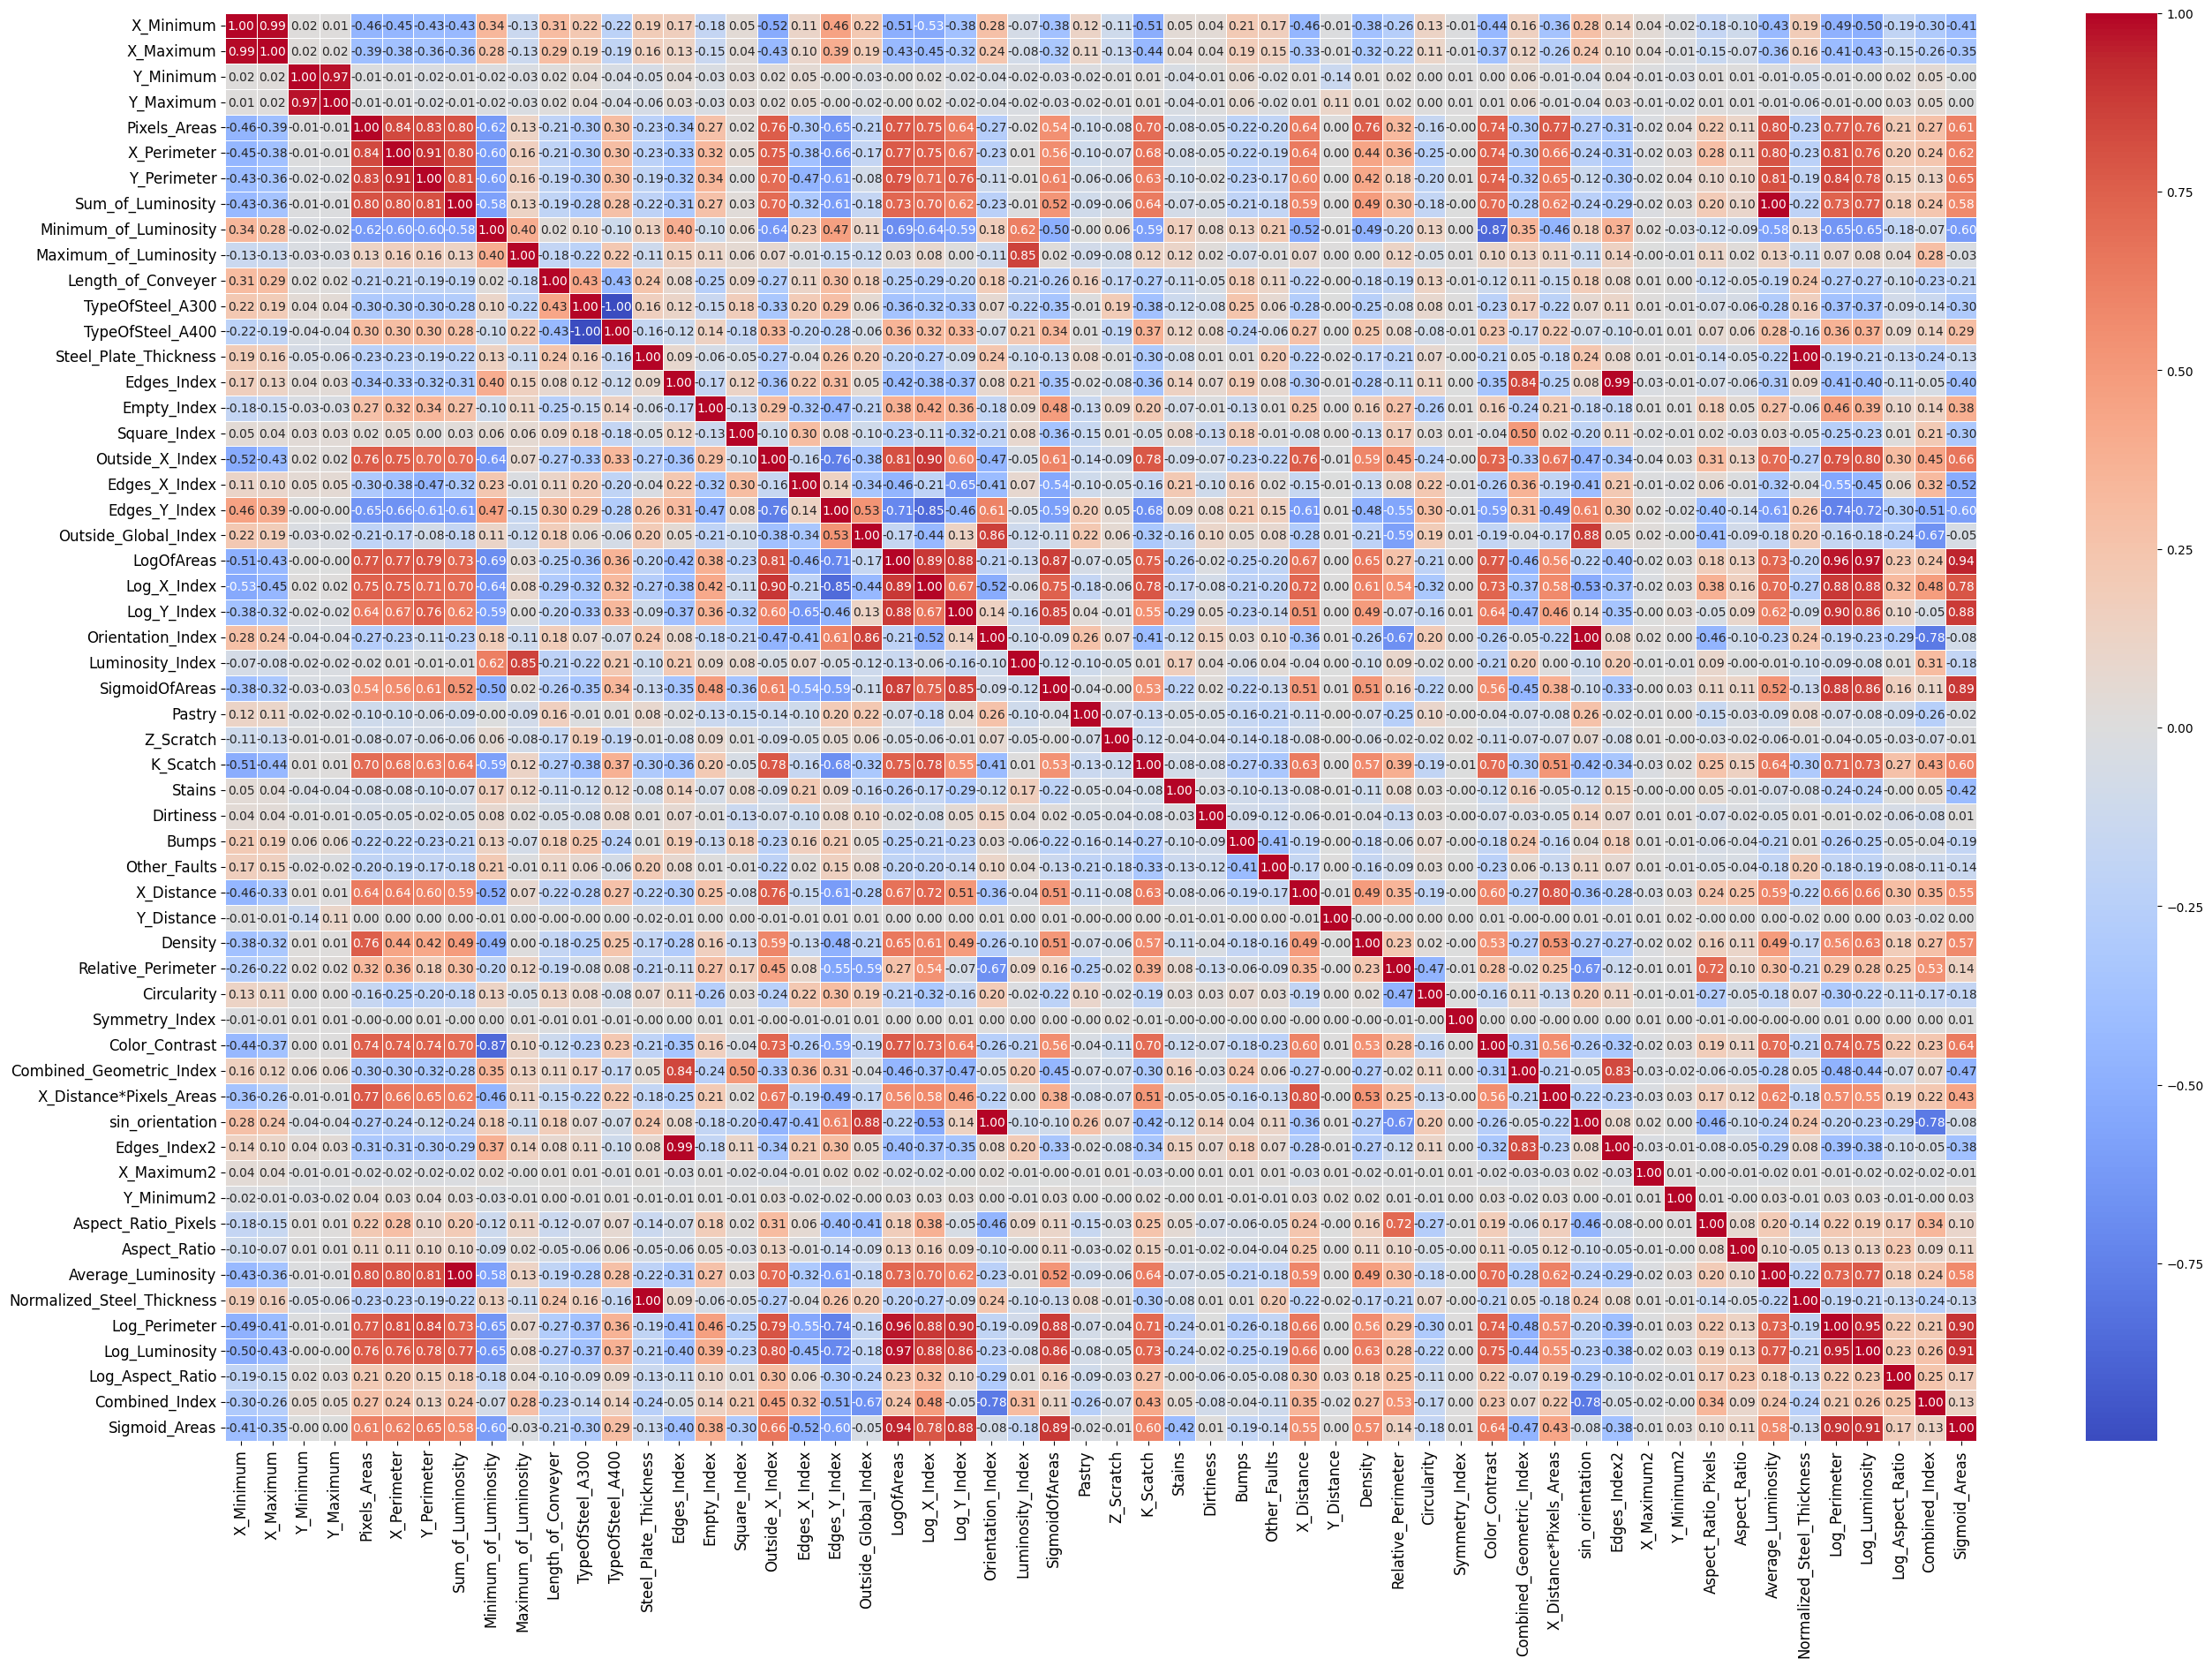

In [28]:
df_corr = df_train.corr()
plt.figure(figsize=(32, 21))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

<Figure size 3200x2100 with 0 Axes>

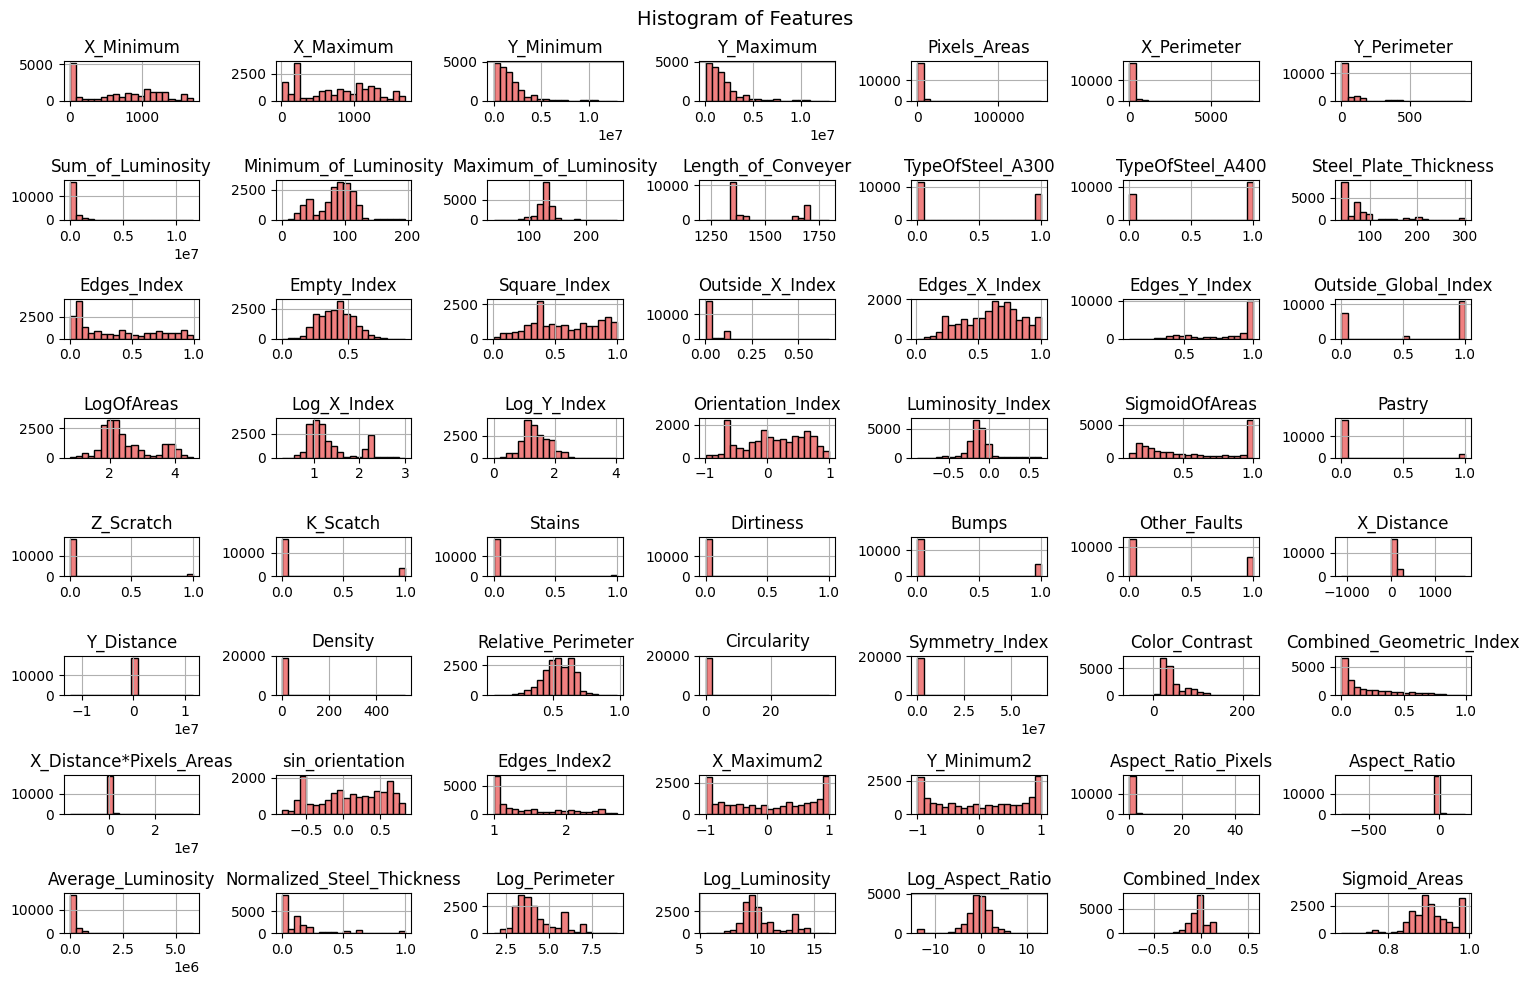

In [18]:
plt.figure(figsize=(32, 21), facecolor="lightgrey")
df_train.hist(bins=20, figsize=(15, 10), color="lightcoral", edgecolor="black", grid=True)
plt.suptitle("Histogram of Features", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 3000x2000 with 0 Axes>

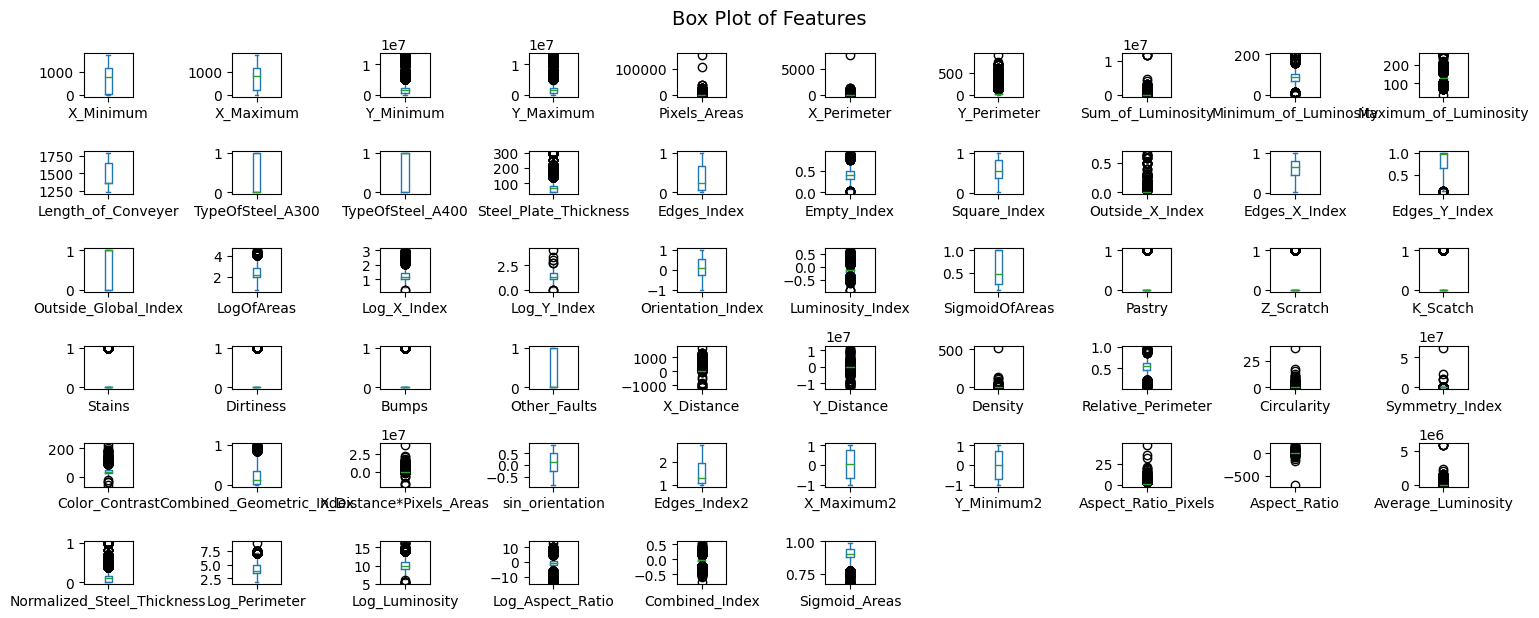

In [19]:
plt.figure(figsize=(30, 20), facecolor="lightgrey")
df_train.plot(kind="box", layout=(10, 10), subplots=True, sharex=False, sharey=False, figsize=(15, 10))
plt.suptitle("Box Plot of Features", fontsize=14)
plt.tight_layout()
plt.show()

In [9]:
df_targets = df_train[targets]
print(f"The sum of values:\n{df_targets.sum(axis=0)}")

The sum of values:
Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64


#### Feature Selection

In [29]:
# Split the data into features (X) and target (y)
features_X = df_train[features]
target_y = df_train["Pastry"]

# Feature Selection (SelectKBest)
select_kbest = SelectKBest(k="all")
fit = select_kbest.fit(features_X, target_y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(features_X.columns)
featureScores = pd.concat([df_columns, df_scores], axis=1)
featureScores.columns = ["Specs", "Score"]
featureScores.nlargest(10, "Score").set_index("Specs")
print(featureScores)

                    Specs        Score
0               X_Minimum   277.482838
1               X_Maximum   230.238434
2               Y_Minimum     4.625133
3               Y_Maximum     5.098733
4            Pixels_Areas   199.222161
5             X_Perimeter   211.440426
6             Y_Perimeter    81.448859
7       Sum_of_Luminosity   168.239549
8   Minimum_of_Luminosity     0.410617
9   Maximum_of_Luminosity   143.490355
10     Length_of_Conveyer   496.307409
11       TypeOfSteel_A300     1.030441
12       TypeOfSteel_A400     1.080744
13  Steel_Plate_Thickness   123.896169
14            Edges_Index     7.180811
15            Empty_Index   349.360066
16           Square_Index   445.103521
17        Outside_X_Index   379.631726
18          Edges_X_Index   200.916081
19          Edges_Y_Index   815.581743
20   Outside_Global_Index  1012.953959
21             LogOfAreas    90.835258
22            Log_X_Index   623.722573
23            Log_Y_Index    25.705335
24      Orientation_Index

#### Model Evaluation and Model Selection

Features -> (19219, 49) Targets -> (19219, 7)


Random Forest - ROC AUC: 0.8702431914202741 - Accuracy: 0.3704474505723205
AdaBoost - ROC AUC: 0.8714908706113758 - Accuracy: 0.3893860561914672


/home/felipe/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/felipe/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Logistic Regression - ROC AUC: 0.7189229677661163 - Accuracy: 0.19229968782518211
Gradient Boosting - ROC AUC: 0.8817996055133188 - Accuracy: 0.3922996878251821
Decision Tree - ROC AUC: 0.6780831415910423 - Accuracy: 0.3144640998959417
Neural Net - ROC AUC: 0.6157346201845167 - Accuracy: 0.2064516129032258


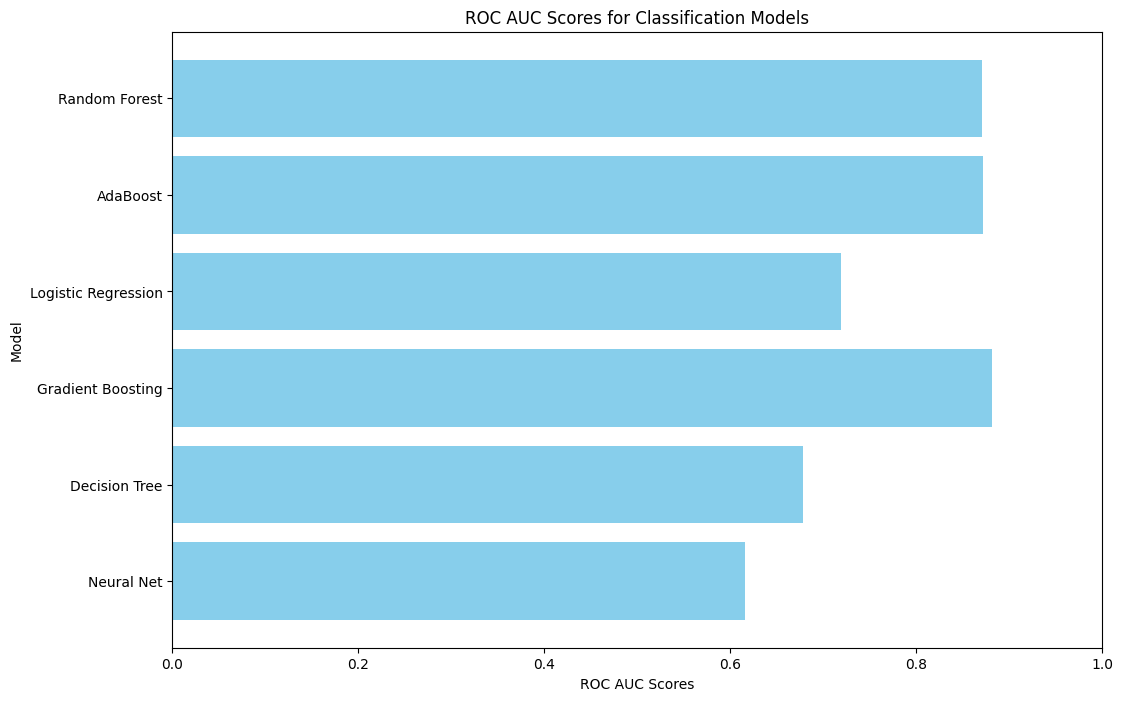

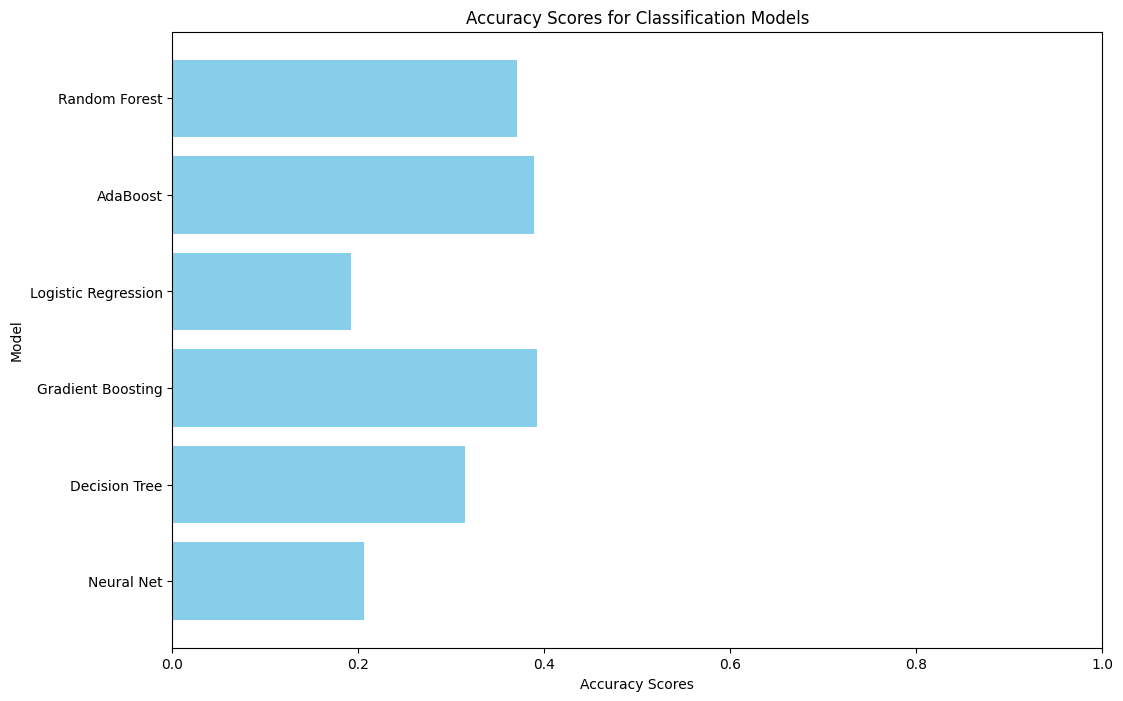

In [30]:
# Model Selection of Regression Models
models = {
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Net": MLPClassifier()
}

# Defining X(features) and Y(targets)
X = df_train.drop(columns=targets)
y = df_train[targets]
print(f"Features -> {X.shape} Targets -> {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)

# Dictionary to store cross-validation scores for each model
accuracy_scores = {}
roc_auc_scores = {}
for name, model in models.items():
    output_classifier = MultiOutputClassifier(model, n_jobs=-1)
    output_classifier.fit(X_train, y_train)
    y_predictions = output_classifier.predict(X_test)    
    y_pred_prob = np.array(output_classifier.predict_proba(X_test))
    y_pred_prob = y_pred_prob[:, :, 1].T
    accuracy = accuracy_score(y_test, y_predictions)
    accuracy_scores[name] = accuracy
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    roc_auc_scores[name] = np.mean(roc_auc)
    print(f"{name} - ROC AUC: {roc_auc} - Accuracy: {accuracy}")

# Plotting the ROC AUC scores
plt.figure(figsize=(12, 8))
plt.barh(list(roc_auc_scores.keys()), list(roc_auc_scores.values()), color="skyblue")
plt.xlabel("ROC AUC Scores")
plt.ylabel("Model")
plt.title("ROC AUC Scores for Classification Models")
plt.xlim(0, 1)  # Set x-axis limit to better visualize ROC AUC scores
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

# Plotting the Accuracy scores
plt.figure(figsize=(12, 8))
plt.barh(list(accuracy_scores.keys()), list(accuracy_scores.values()), color="skyblue")
plt.xlabel("Accuracy Scores")
plt.ylabel("Model")
plt.title("Accuracy Scores for Classification Models")
plt.xlim(0, 1)  # Set x-axis limit to better visualize ROC AUC scores
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

In [31]:
# Hyperparameter Tuning (GridSearchCV)
base_estimator = GradientBoostingClassifier()
model = MultiOutputClassifier(base_estimator)
parameters_grid = {
    "estimator__n_estimators": [50, 75, 100],
    "estimator__max_depth": [10, 20, 30],
    "estimator__max_features": ["auto", "sqrt", "log2"]
}

scorer = make_scorer(f1_score, average="micro") 
grid_search = GridSearchCV(model, parameters_grid, scoring=scorer, cv=5).fit(X_train, y_train)
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_["mean_test_score"]
stds = grid_search.cv_results_["std_test_score"]
parameters = grid_search.cv_results_["params"]
for mean, stdev, param in zip(means, stds, parameters):
    print(f' {mean} {stdev} with: {param}')
print(f"\nBest Score: {grid_search.best_score_} using these Best Parameters: {grid_search.best_params_}")

KeyboardInterrupt: 

#### Model Building and Training

In [12]:
gradient = GradientBoostingClassifier()

# Create a pipeline with preprocessing and RandomForestClassifier
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", MultiOutputClassifier(gradient))])

pipeline.fit(X_train, y_train)

y_predictions = pipeline.predict(X_test)
y_pred_prob = np.array(pipeline.predict_proba(X_test))


#### Model Evaluation and Validation

In [13]:
accuracy = accuracy_score(y_test, y_predictions)
classification_rep = classification_report(y_test, y_predictions, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.3891779396462019
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.07      0.12       346
           1       0.60      0.51      0.55       280
           2       0.90      0.91      0.90       846
           3       0.75      0.74      0.75       144
           4       0.62      0.07      0.13       114
           5       0.62      0.31      0.41      1175
           6       0.59      0.21      0.31      1701

   micro avg       0.71      0.38      0.50      4606
   macro avg       0.66      0.40      0.45      4606
weighted avg       0.66      0.38      0.45      4606
 samples avg       0.85      0.41      0.39      4606



#### Submission

In [17]:
df_test = FeatureEngineering().fit_transform(df_test)
final_pred = pipeline.predict(df_test)
result_df = pd.DataFrame(final_pred, columns=y.keys())
result_df.insert(0, "id", df_test.index)
result_df.to_csv("../my_submission.csv", index=False)
result_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0,0,0,0,0,0,0
1,19220,0,0,0,0,0,0,0
2,19221,0,0,0,0,0,0,0
3,19222,0,0,0,0,0,0,0
4,19223,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
12809,32028,0,0,0,0,0,0,0
12810,32029,0,0,0,0,0,0,0
12811,32030,0,0,1,0,0,0,0
12812,32031,1,0,0,0,0,0,0
